In [1]:
#ツイートのテキスト読み込み
test = open("Datas/N_extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("Datas/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
training_samples = 8000 # training data 80 : validation data 20
validation_samples = len(lines) - training_samples
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 18852 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [3]:
tdata = lines[-100:]
tlabel = label[-100:]
print(tdata[-3])

アニメ映画 原案 特徴 猫 キャラクター 独特 ファンタジー 漫画家 展覧会 開催 繊細 色 鮮やか カラー イラスト 貴重 漫画 原稿 問合せ 岩手県立美術館 ima info



In [4]:
sequences2 = tokenizer.texts_to_sequences(tdata)
test_data = pad_sequences(sequences2, maxlen=maxlen)

categorical_labels2 = to_categorical(tlabel)
test_labels = np.asarray(categorical_labels2)

In [5]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [6]:
def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()
model.add(Embedding(20000, 50, input_length=maxlen))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_initializer=weight_variable))
model.add(LSTM(32, return_sequences=True, kernel_initializer=weight_variable))
#model.add(Dropout(0.5))
model.add(LSTM(32, kernel_initializer=weight_variable))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#opt = Adam(lr=1e-4, beta_1 = 0.9, beta_2 = 0.999)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='N_method1_LSTM1024_model.png')

early_stopping = EarlyStopping(patience=0, verbose=1)

ValueError: If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
- If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
- If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.

In [8]:
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=300,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 9s 1ms/step - loss: 0.6932 - acc: 0.4874 - macro_precision: 0.4738 - macro_recall: 0.4922 - macro_f_measure: 0.4800 - val_loss: 0.6928 - val_acc: 0.5170 - val_macro_precision: 0.5595 - val_macro_recall: 0.5157 - val_macro_f_measure: 0.5361
Epoch 2/100
8000/8000 [==============================] - 6s 733us/step - loss: 0.6652 - acc: 0.5800 - macro_precision: 0.6079 - macro_recall: 0.5820 - macro_f_measure: 0.5939 - val_loss: 0.5903 - val_acc: 0.6555 - val_macro_precision: 0.6577 - val_macro_recall: 0.6550 - val_macro_f_measure: 0.6563
Epoch 3/100
8000/8000 [==============================] - 6s 730us/step - loss: 0.5097 - acc: 0.7330 - macro_precision: 0.7406 - macro_recall: 0.7321 - macro_f_measure: 0.7363 - val_loss: 0.4834 - val_acc: 0.7425 - val_macro_precision: 0.7661 - val_macro_recall: 0.7418 - val_macro_f_measure: 0.7538
Epoch 4/100
8000/8000 [==============================] - 

In [9]:
loss_and_metrics = model.evaluate(test_data, test_labels)
print(loss_and_metrics)

100/100 [==============================] - 0s 3ms/step
[0.4251613473892212, 0.83, 0.6965192317962646, 0.7547446060180664, 0.723711531162262]


In [11]:
classes = model.predict_classes(test_data, batch_size=10)
print(test_labels == classes)
print(classes)
print(tlabel)

False
[1 0 0 0 0 1 0 1 0 1]
['1\n', '0\n', '0\n', '0\n', '0\n', '0\n', '0\n', '1\n', '0\n', '1\n']


G:\ganda\conda\tensorflow_test\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


In [32]:
print(tdata[0])

祝 成人 ドリンク 杯 無料 土日 期間 今年 新成人 ファースト ドリンク サービス 記念 瞬間 遠野 醸造 ビール 乾杯 詳細



In [8]:
model.save('N_method1_model_LSTM1024.h5')

FileNotFoundError: [Errno 2] No such file or directory: 'RNN_tweet/Figs/N_method1/N_acc.png'

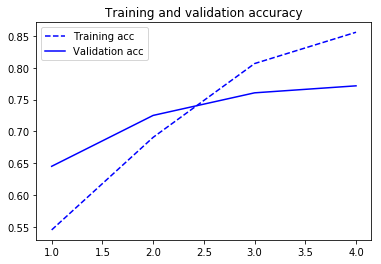

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['macro_precision']
val_precision = history.history['val_macro_precision']
recall = history.history['macro_recall']
val_recall = history.history['val_macro_recall']
f_measure = history.history['macro_f_measure']
val_f_measure = history.history['val_macro_f_measure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method1/N_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method1/N_loss.png")

plt.figure()

plt.plot(epochs, precision, 'b--', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation presicion')
plt.title('Training and validation precision')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method1/N_precision.png")

plt.figure()

plt.plot(epochs, recall, 'b--', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method1/N_recall.png")

plt.figure()

plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method1/N_f_measure.png")

fig = plt.figure()

ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('validation acc and validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.savefig("RNN_tweet/Figs/N_method1/acc_loss.png")
plt.show()


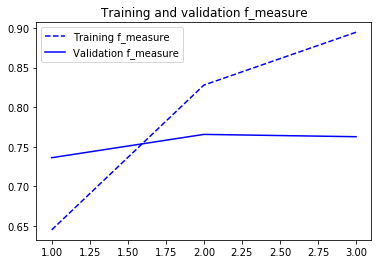

In [19]:
plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()

plt.savefig("N_f_measure.png")
plt.show()

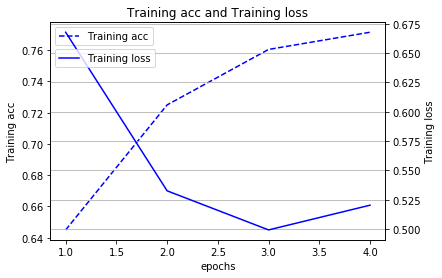

In [13]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.show()